In [1]:
import pandas as pd
import numpy as np
from bff_processor.Systogram import Systogram
from bff_processor.bff_meta import *
from bff_processor.sig_op_func import *
from bff_processor.bff_cuts import bff_1, bff_2, reg_filter
from bff_processor.plotting_utils import unc_plot, boost2unc
from bff_processor.utils import nratio_plot_template, hist2unc, vunc2nom, chiSquared
import os
import re
from time import perf_counter
import boost_histogram as bh
import pyarrow.feather as feather
import zfit
from zfit import z
from math import pi
import mplhep as hep
hep.set_style(hep.style.CMS)
plt.rcParams.update({
    "text.usetex": True,
})

/home/ryan/Develop/Physics/env/lib/python3.8/site-packages/zfit/__init__.py:37: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn("TensorFlow warnings are by default suppressed by zfit."
/tmp/ipykernel_25443/3838827165.py:18: FutureWarning: ``set_style`` is deprecated: Naming convention is changing to match mpl. Use ``mplhep.style.use()``.
  hep.set_style(hep.style.CMS)


In [2]:
import pickle

In [3]:
class LogNormPDF(zfit.pdf.ZPDF):
    """1-dimensional PDF implementing the exp(alpha * x) shape."""
    _PARAMS = ['sigma', 'theta', 'mean']  # specify which parameters to take

    def lognorm(self, data, module, sigma=.5, theta=100, mean=90):
        return 1./((data-theta)*sigma*2*pi)*module.exp(-(module.log((data-theta)/mean))**2/(2*sigma**2))
        
    def _unnormalized_pdf(self, x):  # implement function
        data = z.unstack_x(x)
        sigma = self.params['sigma']
        theta = self.params['theta']
        mean = self.params['mean']
        return self.lognorm(data, z.numpy, sigma=sigma, theta=theta, mean=mean)
    
    def par2ufloat(self, name): 
        assert self.result, "Need to add result object"
        from uncertainties import ufloat
        return  ufloat(self.result.params[name]['value'], self.result.params[name]['minuit_hesse']['error'])

    def uncertainty(self, x):
        import uncertainties.unumpy as unp
        data = x
        name = []
        values = []
        for x in self.result.params:
            name.append(x.name)
            values.append(x.value().numpy())
        import uncertainties
        popt = uncertainties.correlated_values(values, self.result.covariance())
        
        y = self.lognorm(data, unp, **{n:p for n, p in zip(name,popt)}) 
        y = y * np.sum(self.pdf(data)) / np.sum(y)
        return y  

In [4]:
try:
    sigma    = zfit.Parameter("sigma"   , .8, 0, 1.5)
    theta = zfit.Parameter("theta", 80,  0, 100)
    mean = zfit.Parameter("mean", 91,  0, 800)
except:
    print("already defined")

2021-09-02 14:29:44.301510: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [5]:
def fit_lognorm(y, weights, obs, verbose=False):
    lognorm = LogNormPDF(obs=obs, sigma=sigma, theta=theta, mean=mean)

    # load the data
    data = zfit.Data.from_numpy(obs=obs, array=y, weights=weights)
    
    # build the loss
    nll = zfit.loss.UnbinnedNLL(model=lognorm, data=data)

    # minimize
    minimizer = zfit.minimize.Minuit()
    result = minimizer.minimize(nll)
    lognorm.result = result
    
    # calculate errors
    param_errors = result.hesse()
    
    if verbose: print(result)
    
    return lognorm, data

In [6]:
def summarize_fits(reg_dict, name):
    with open('fits/{}.txt'.format(name), 'w') as f:
        print(name, file=f)
        for reg in  reg_dict: 
            if reg == "abcd": continue
            print(reg_dict[reg]['lognorm'].result, file=f)
            fit = reg_dict[reg]['unc']
            data = reg_dict[reg]['hist_unc']
            print("fit {} chi2: {:.2f}".format(reg, chiSquared(fit,data,dof=4)), file=f)
            if 'SR' in reg:
                print("ABCD pred {} chi2: {:.2f}".format(reg, chiSquared(reg_1_MC['abcd'],data,dof=4)), file=f)
    with open('fits/{}.pkl'.format(name), 'wb') as f:
        pickle.dump(reg_dict['abcd'], f, protocol=2)

In [8]:
era = '2018'
if era=='2016':
    lumi=35.50
if era=='2017':
    lumi=41.85
if era=='2018':
    lumi=58.88

minMass = 110
maxMass = 800

In [9]:
df = feather.read_feather('data/combined_{}.feather'.format(era))
df = df[(df.DiLepMass > minMass) & (df.DiLepMass < maxMass)]

In [10]:
names = np.unique(df['name'])
types = np.unique(df['type'])
name_dict = { t:np.unique(df[df['type']==t]['name']) for t in types}
types, name_dict

(array(['bck', 'data', 'sig'], dtype=object),
 {'bck': array(['ZToEE_M_120_200', 'ZToEE_M_200_400', 'ZToEE_M_400_800',
         'ZToEE_M_50_120', 'ZToEE_M_800_1400', 'ZToMuMu_M_120_200',
         'ZToMuMu_M_200_400', 'ZToMuMu_M_400_800', 'ZToMuMu_M_50_120',
         'ZToMuMu_M_800_1400', 'mc_santitop', 'mc_stop', 'mc_ttbar',
         'mc_ww', 'mc_wz', 'mc_zz'], dtype=object),
  'data': array(['data_el', 'data_mu'], dtype=object),
  'sig': array(['BFFZprimeToMuMu_M_125_dbs0p04', 'BFFZprimeToMuMu_M_150_dbs0p04',
         'BFFZprimeToMuMu_M_175_dbs0p04', 'BFFZprimeToMuMu_M_200_dbs0p04',
         'BFFZprimeToMuMu_M_200_dbs0p5', 'BFFZprimeToMuMu_M_200_dbs1p0',
         'BFFZprimeToMuMu_M_250_dbs0p04', 'BFFZprimeToMuMu_M_300_dbs0p04',
         'BFFZprimeToMuMu_M_350_dbs0p04', 'BFFZprimeToMuMu_M_350_dbs0p5',
         'BFFZprimeToMuMu_M_350_dbs1p0', 'BFFZprimeToMuMu_M_400_dbs0p04',
         'BFFZprimeToMuMu_M_450_dbs0p04', 'BFFZprimeToMuMu_M_500_dbs0p04',
         'BFFZprimeToMuMu_M_500_dbs0p5

In [11]:
minv, maxv = minMass, maxMass
delta = 5
nSteps = int((maxv-minv)/delta + 1)
print(nSteps)
bh_axis=bh.axis.Regular(nSteps,minv,maxv)
(lambda x: x.edges[::len(x)])(bh_axis)

139


array([110., 800.])

In [12]:
def fit_and_plot_from_df(top, bottom,  tdf, bh_axis=bh.axis.Regular(nSteps,minv,maxv), verbose=False, weight='Weight', label=""):
    y = tdf['DiLepMass'].to_numpy()
    weights = tdf[weight].to_numpy()
    limits = (lambda x: x.edges[::len(x)])(bh_axis)
    obs = zfit.Space("x", limits=limits)
    lognorm, data = fit_lognorm(y, weights, obs, verbose=verbose)
    sumW, sumW2 = np.sum(data.weights.numpy()), np.sum(data.weights.numpy()**2)
    std = sumW2**.5
    from uncertainties import ufloat
    sum_ufloat = ufloat(sumW, std)
                        
    #fill histogram
    hist = bh.Histogram(bh_axis, storage=bh.storage.Weight())
    hist.fill(data.value().numpy().reshape(-1), weight=data.weights.numpy())
    x = hist.axes[0].centers
    n_bins = len(x)
    plot_scaling = sumW / n_bins * obs.area()
    plot_scaling_unc = sum_ufloat * ufloat(1./ n_bins * obs.area(),0)
    top.errorbar(x, hist.values(), yerr=hist.variances()**.5, label=label, color='black',zorder=1)
    unc = lognorm.uncertainty(x) * plot_scaling_unc
    unc_plot(top, x, unc, label='fit {}'.format(label), fill_between=True, color='maroon',zorder=2)
    
    hist_unc = hist2unc(hist)
    unc_plot(bottom, x, unc/(hist.values()+1e-12), label='fit {}'.format(label), fill_between=True, color='maroon',zorder=2)
    unc_plot(bottom, x, hist_unc/(hist.values()+1e-12), label='data {}'.format(label), fill_between=True, color='black',zorder=1)
    bottom.plot(limits,[1,1])
    return {'lognorm':lognorm, 'sumW':sumW, 'std':std, 'unc':unc, 'x':x, 'hist_unc': hist_unc}

In [13]:
def fit_and_abcd(nJets,data_type, verbose=False):
    fig, axes = nratio_plot_template(nPlots=[2,2],rps = 2, figsize=[20,20])
    reg_keys = {'SR{}_{}':([0,0], r'$SR_b^{\mu\mu}$'),
    'CR{}0_{}':([1,0], r'$CR_j^{\mu\mu}$'),
    'CR{}3_{}':([0,1], r'$CR_b^{ee}$'),
    'CR{}4_{}':([1,1], r'$CR_j^{ee}$')}
    unp_pred = {}
    unp_hist = {}
    reg_dict ={}
    isData = "data" in data_type
    for name, ((i,j), region_text) in reg_keys.items():
        name = name.format(nJets, 'nom')
        print(name)
        
        top, bottom = axes[i][j]

        tdf = df[(df.type==data_type) & (df[name]==1)]
        label='{} {} Jet'.format(region_text,nJets)
        if not("SR" in name and isData): 
            plot_dict = fit_and_plot_from_df(top, bottom, tdf, label=label, verbose=verbose)
            unp_pred[name] = plot_dict['unc']
            unp_hist[name] = plot_dict['hist_unc']
            reg_dict[name] = plot_dict
            top.set_yscale('log')
            top.set_ylim(bottom=1e-1)
            top.legend()
        
        bottom.set_xlabel('DiLepMass [GeV]')
        top.set_ylabel('Count per 5 GeV')
        hep.cms.label(loc=0,ax=top,lumi=lumi,year=era, data=isData)
        bottom.set_ylim(0,2)
        
    
    top, bottom = axes[0][0]
    x = plot_dict['x']
    sr_pred = unp_pred['CR{}0_nom'.format(nJets, 'nom')]*unp_pred['CR{}3_nom'.format(nJets, 'nom')]/unp_pred['CR{}4_nom'.format(nJets, 'nom')]
    unc_plot(top, x, sr_pred, label='ABCD pred', fill_between=True, color='blue',zorder=3)
    if not isData:
        sr_hist = (unp_hist['SR{}_nom'.format(nJets, 'nom')])
        unc_plot(bottom, x, sr_pred/(sr_hist+1e-12), fill_between=True, color='blue',zorder=3)
    top.set_yscale('log')
    top.set_ylim(bottom=1e-1)
    top.legend()
    reg_dict['abcd'] = sr_pred
    return fig, reg_dict

[]
SR1_nom


/tmp/ipykernel_25443/4205438541.py:17: UserWarning: The function <function Space.area at 0x7f8d331f39d0> may does not return the actual area/limits but rather the rectangular limits. <zfit Space obs=('x',), axes=None, limits=(array([[110.]]), array([[800.]]))> can also have functional limits that are arbitrarily defined and lay inside the rect_limits. To test if a value is inside, use `inside` or `filter`.
  plot_scaling = sumW / n_bins * obs.area()


CR10_nom
CR13_nom
CR14_nom


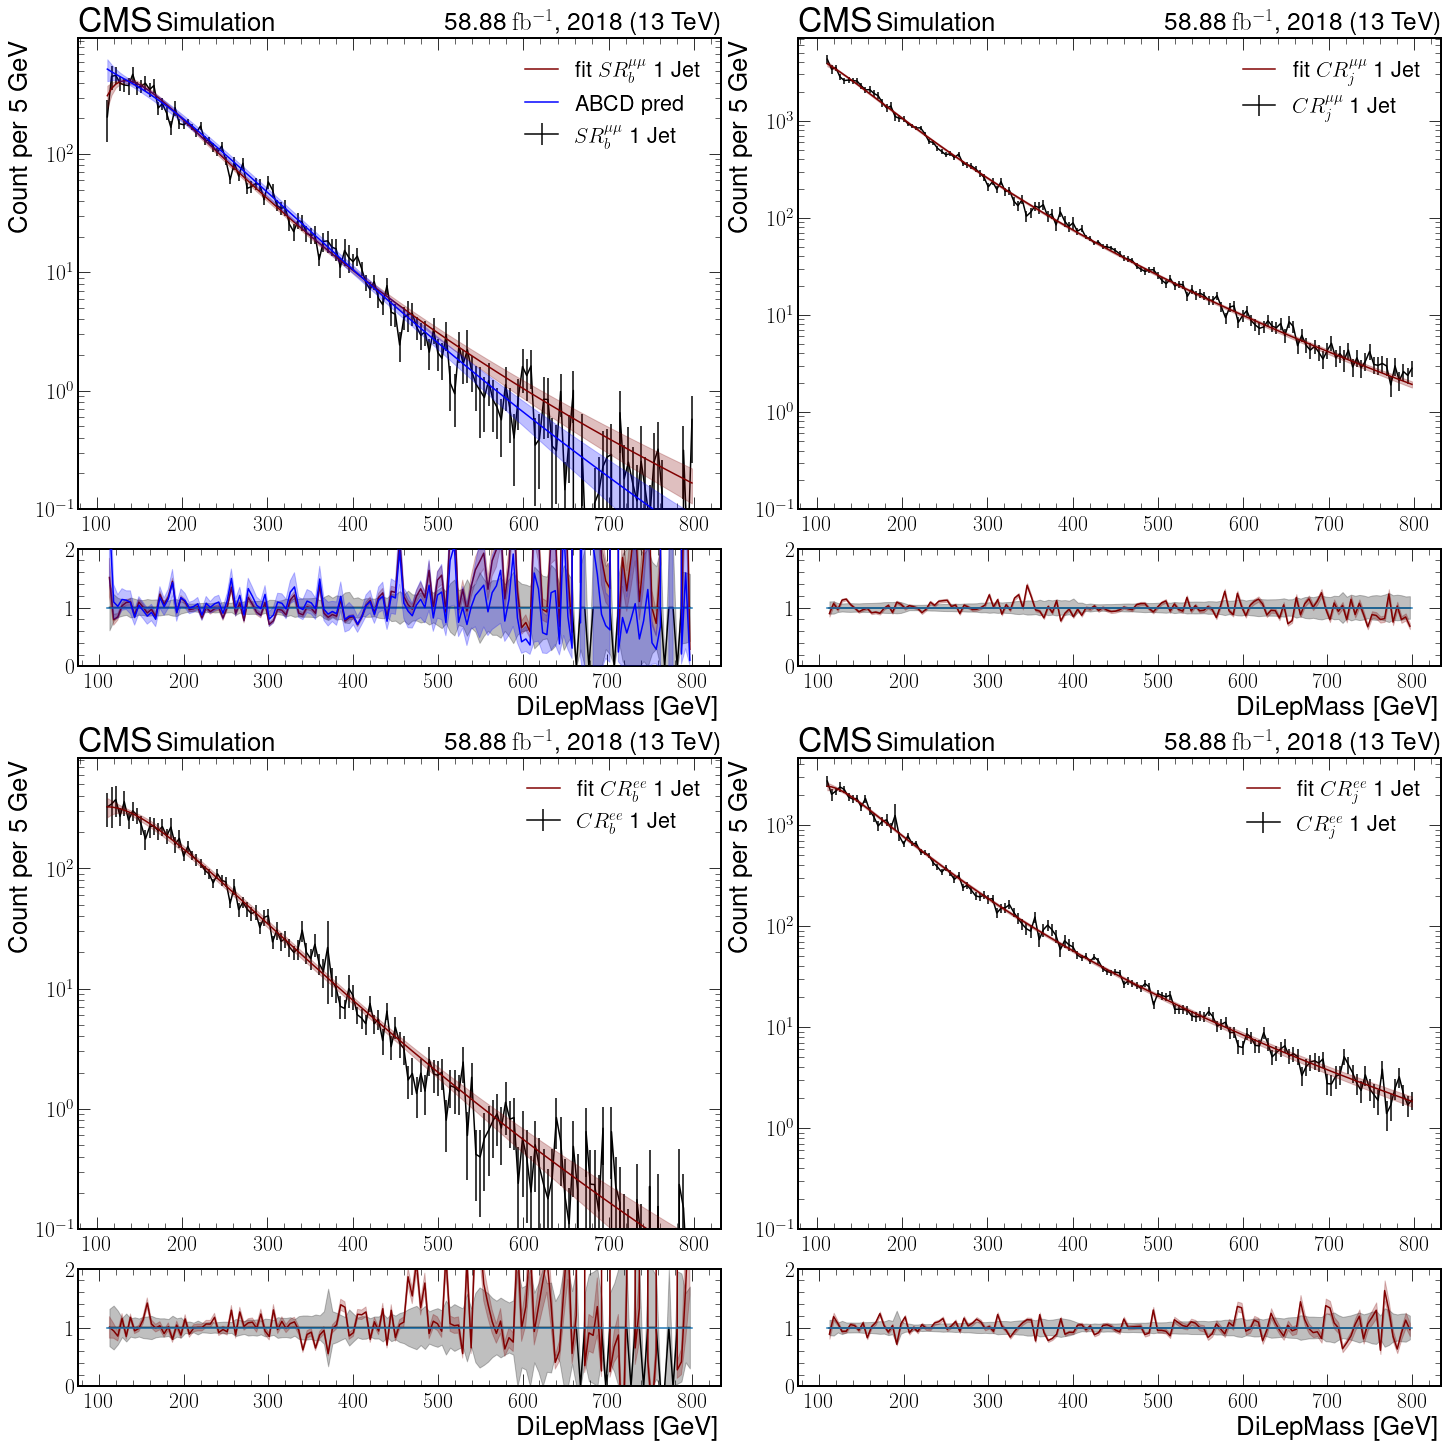

In [14]:
fig, reg_1_MC = fit_and_abcd(1, 'bck')
fig.savefig('fits/stat_lognorm_fit_1J_mc_{}.pdf'.format(era))
summarize_fits(reg_1_MC, "1_jet_MC_{}".format(era))

[]
SR2_nom
CR20_nom
CR23_nom
CR24_nom


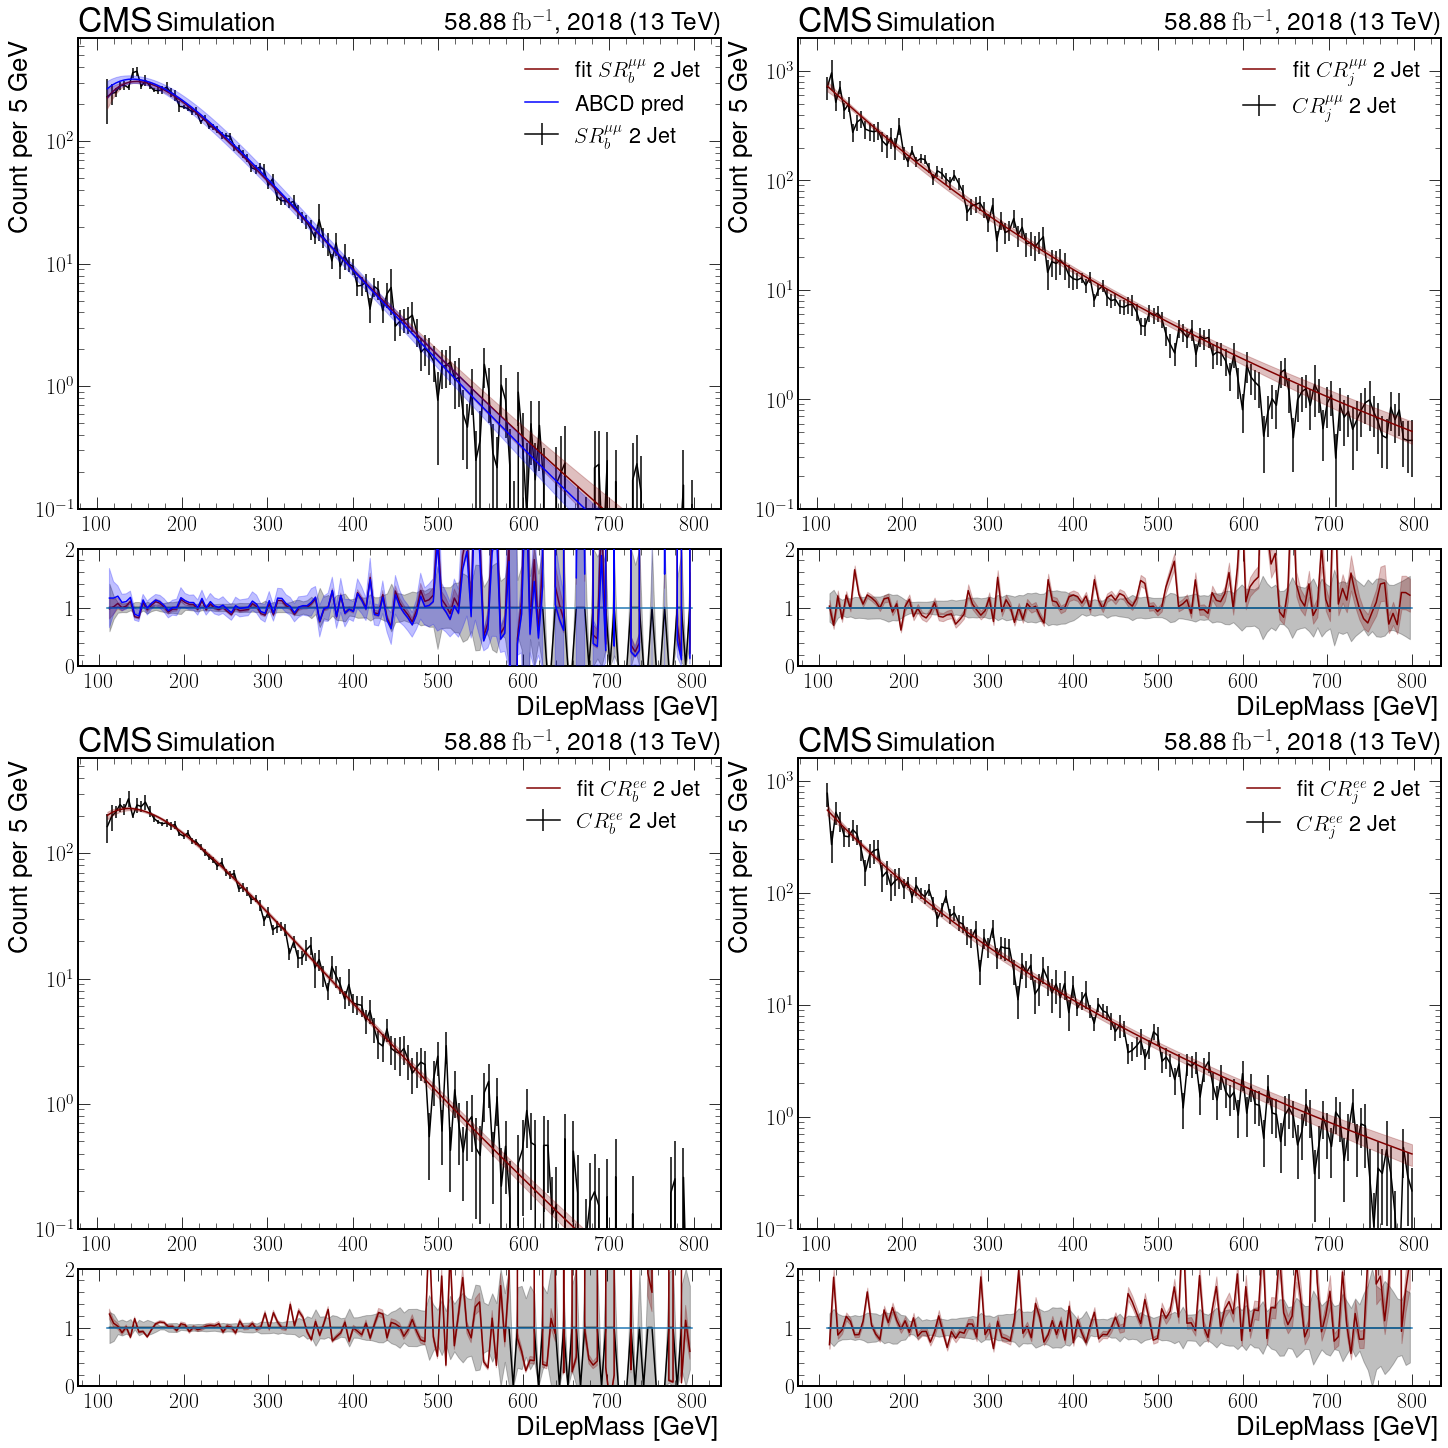

In [15]:
fig, reg_2_MC = fit_and_abcd(2, 'bck', verbose=False)
fig.savefig('fits/stat_lognorm_fit_2J_mc_{}.pdf'.format(era))
summarize_fits(reg_2_MC, "2_jet_MC_{}".format(era))

[]
SR1_nom
CR10_nom
CR13_nom
CR14_nom


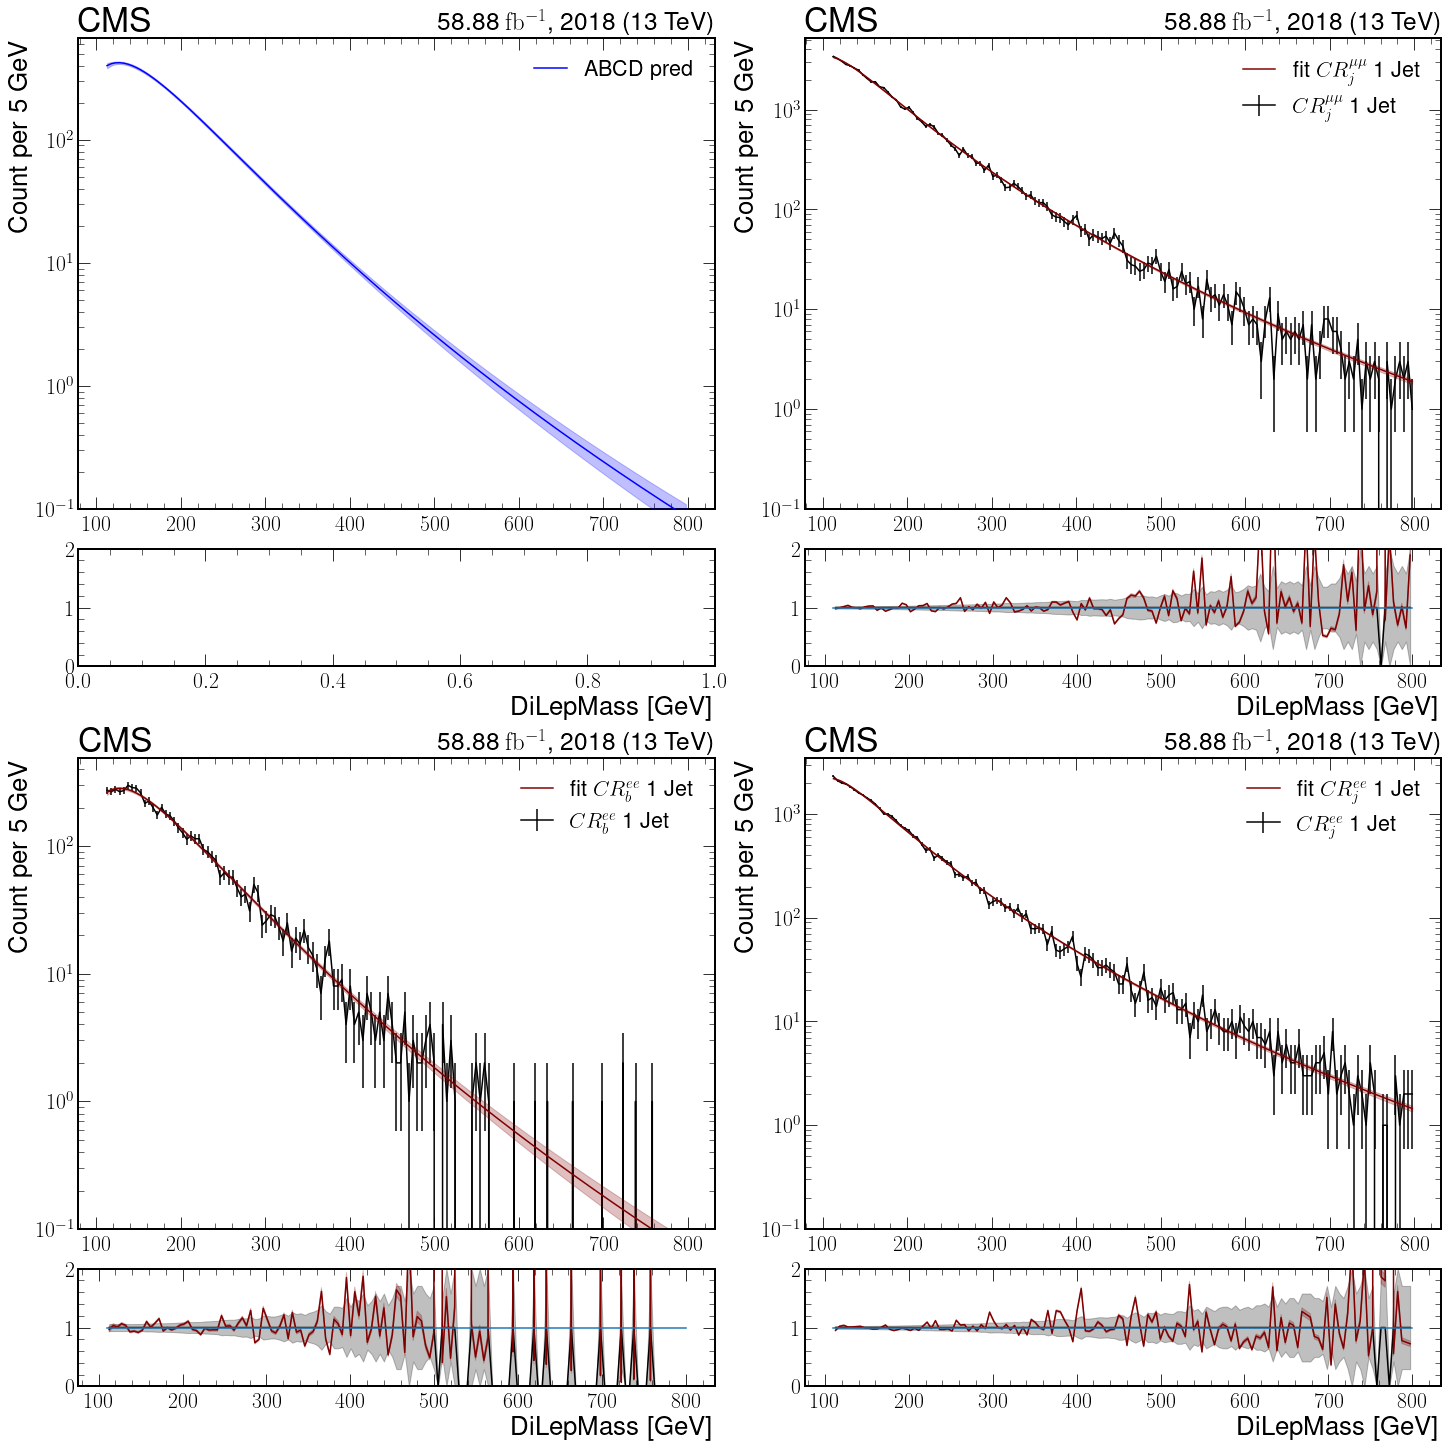

In [16]:
fig, reg_1_data = fit_and_abcd(1, 'data')
fig.savefig('fits/stat_lognorm_fit_1J_data_{}.pdf'.format(era))
summarize_fits(reg_1_data, "1_jet_data_{}".format(era))

[]
SR2_nom
CR20_nom
CR23_nom
CR24_nom


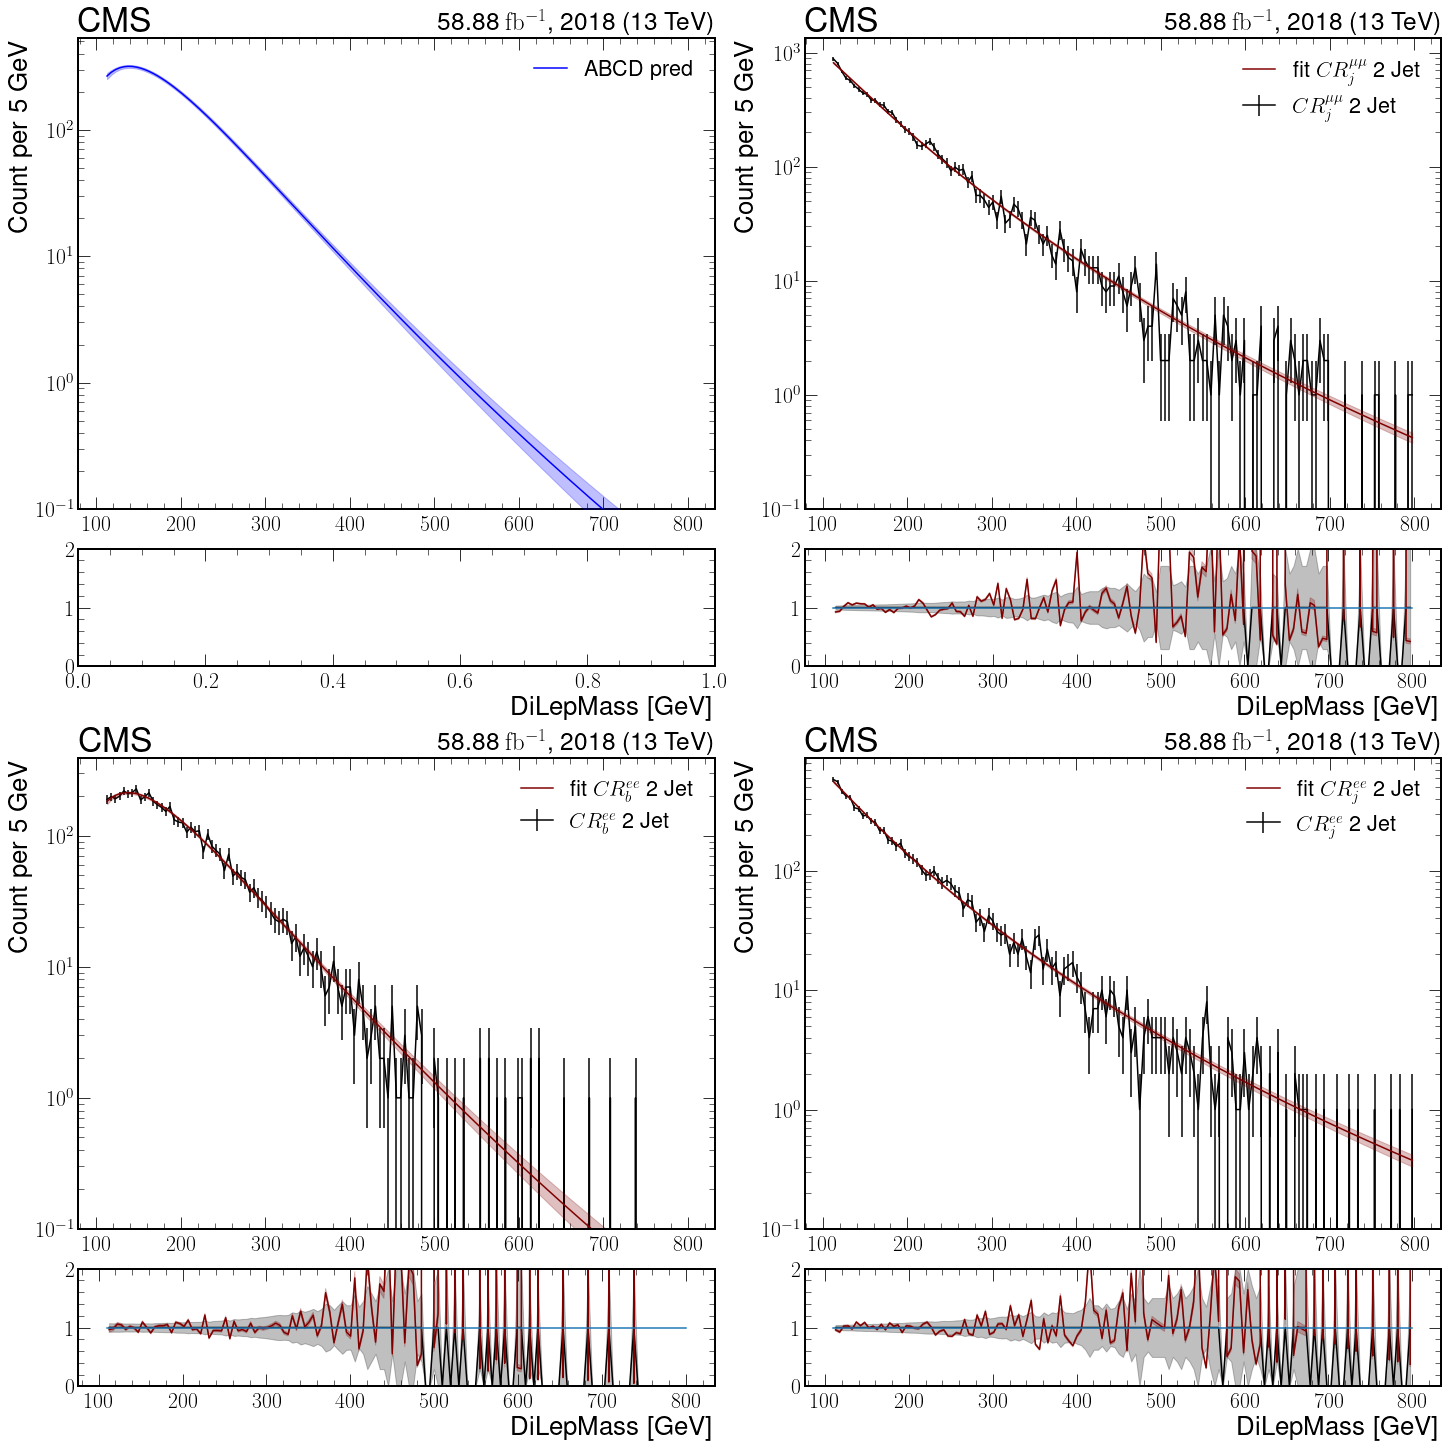

In [17]:
fig, reg_2_data =fit_and_abcd(2, 'data')
fig.savefig('fits/stat_lognorm_fit_2J_data_{}.pdf'.format(era))
summarize_fits(reg_2_data, "2_jet_data_{}".format(era))

In [18]:
def comp_plots(reg_dict,reg_data_dic, nJets):
    fig, axes = nratio_plot_template(nPlots=[2,2],rps = 2, figsize=[20,20])
    reg_keys = {'SR{}_{}':([0,0], r'$SR_b^{\mu\mu}$'),
    'CR{}0_{}':([1,0], r'$CR_j^{\mu\mu}$'),
    'CR{}3_{}':([0,1], r'$CR_b^{ee}$'),
    'CR{}4_{}':([1,1], r'$CR_j^{ee}$')}
    for name, ((i,j), region_text) in reg_keys.items():
        name = name.format(nJets, 'nom')
        print(name)
        x = reg_dict[name]['x']
        top, bottom = axes[i][j]

        label='{} {} Jet'.format(region_text,nJets)
        if not("SR" in name): 
            unc_plot(top, x, reg_data_dic[name]['unc'], label='data fit {}'.format(region_text), fill_between=True, color='blue',zorder=2)    
            unc_plot(bottom, x, reg_data_dic[name]['unc']/vunc2nom(reg_dict[name]['unc']), label='data fit {}'.format(region_text), fill_between=True, color='blue',zorder=2)    
        
        unc_plot(top, x, reg_dict[name]['unc'], label='MC fit {}'.format(region_text), fill_between=True, color='maroon',zorder=2) 
        unc_plot(bottom, x, reg_dict[name]['unc']/vunc2nom(reg_dict[name]['unc']), label='data fit {}'.format(region_text), fill_between=True, color='maroon',zorder=1)    
        if ("SR" in name): 
            unc_plot(top, x, reg_data_dic['abcd'], label='data ABCD {}'.format(region_text), fill_between=True, color='blue',zorder=2)  
            unc_plot(top, x, reg_dict['abcd'], label='mc ABCD {}'.format(region_text), fill_between=True, color='green',zorder=2)  
            unc_plot(bottom, x, reg_data_dic['abcd']/vunc2nom(reg_dict[name]['unc']), label='data ABCD {}'.format(region_text), fill_between=True, color='blue',zorder=2)  
            unc_plot(bottom, x, reg_dict['abcd']/vunc2nom(reg_dict[name]['unc']), label='mc ABCD {}'.format(region_text), fill_between=True, color='green',zorder=2)   
            
            unc_plot(top, x, reg_dict[name]['hist_unc'], label='MC {}'.format(region_text), fill_between=False, color='purple',zorder=0)  
            unc_plot(bottom, x, reg_dict[name]['hist_unc']/vunc2nom(reg_dict[name]['unc']), label='MC {}'.format(region_text), fill_between=False, color='purple',zorder=0)  
            
        top.set_yscale('log')
        top.set_ylim(bottom=1e-1)
        top.legend()
        bottom.set_xlabel('DiLepMass [GeV]')
        top.set_ylabel('Count per 5 GeV')
        hep.cms.label(loc=0,ax=top,lumi=lumi,year=era)
        bottom.set_ylim(0,2)
    return fig

[]
SR1_nom
CR10_nom
CR13_nom
CR14_nom


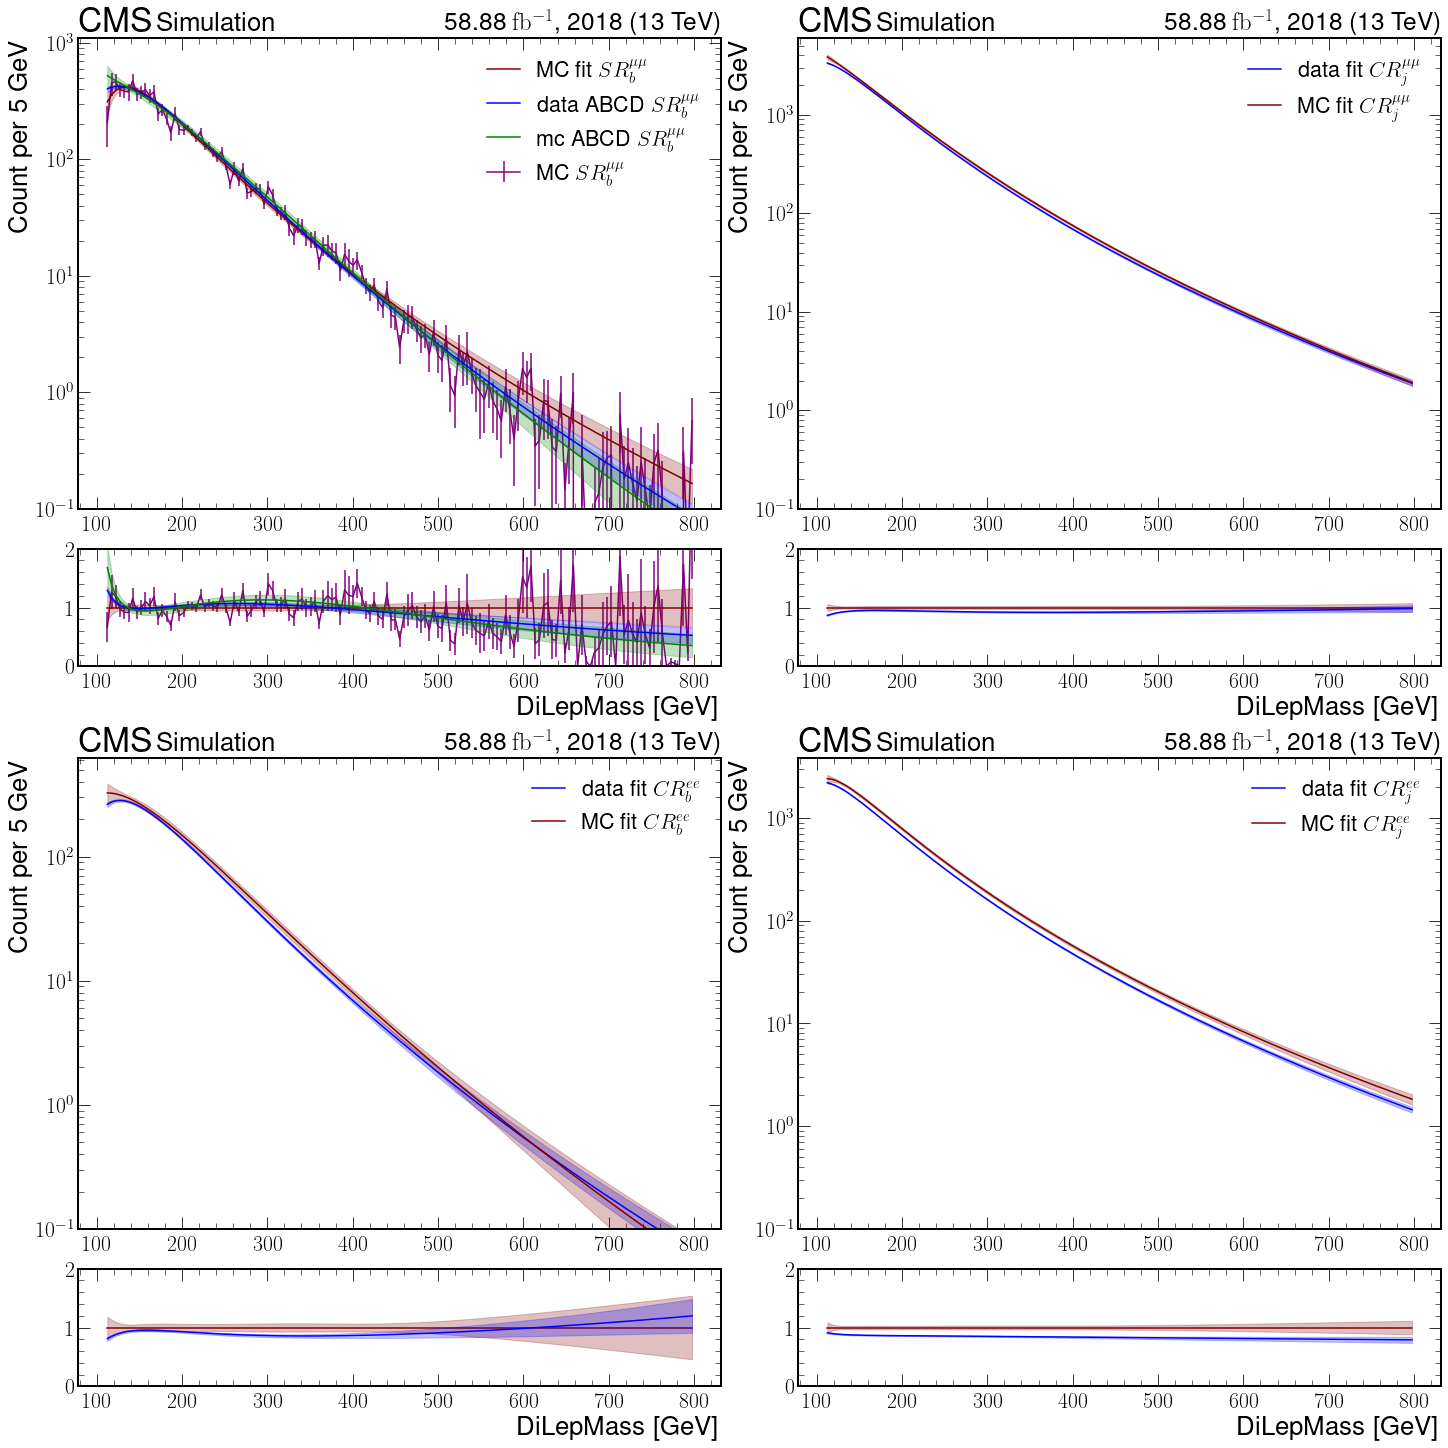

In [19]:
fig = comp_plots(reg_1_MC,reg_1_data, 1)
fig.savefig('fits/fit_comparision_1_{}.pdf'.format(era))

[]
SR2_nom
CR20_nom
CR23_nom
CR24_nom


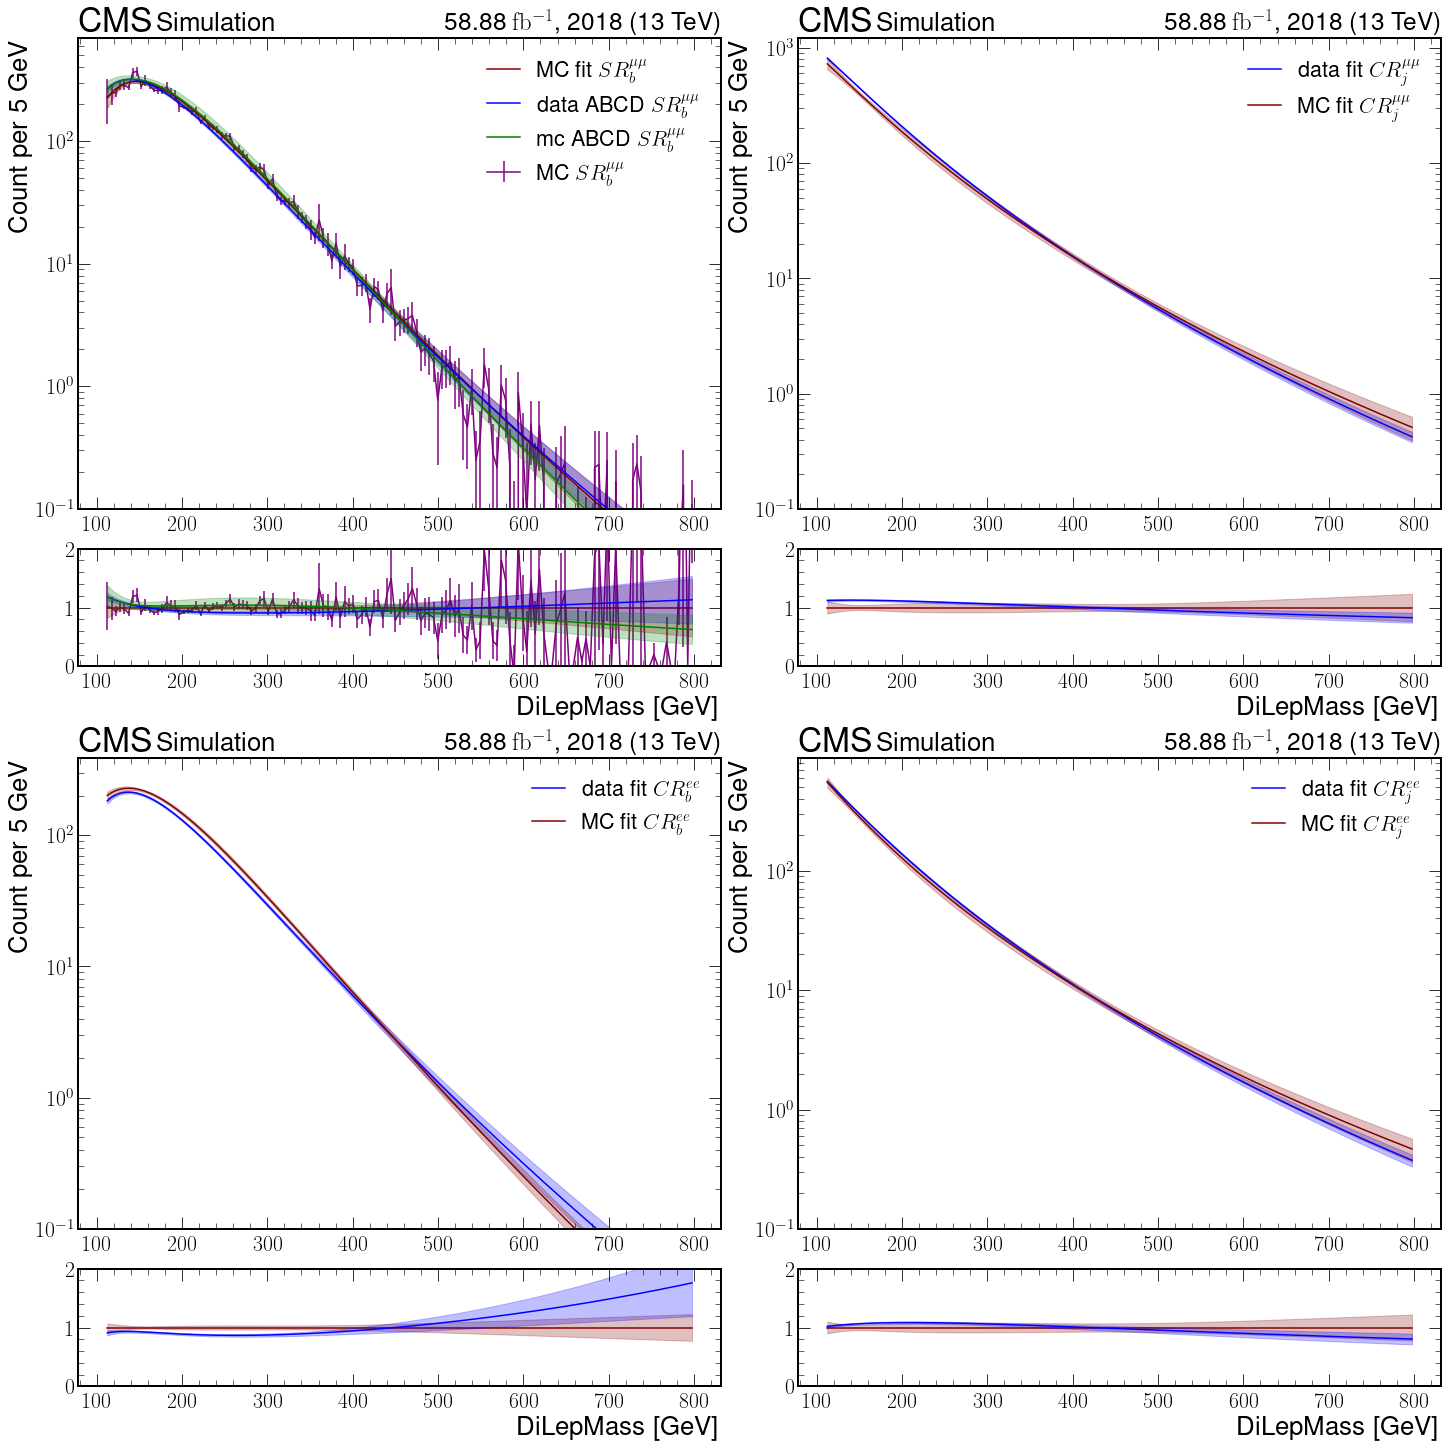

In [20]:
fig = comp_plots(reg_2_MC,reg_2_data, 2)
fig.savefig('fits/fit_comparision_2_{}.pdf'.format(era))

In [21]:
for reg in reg_2_MC:
    print(reg_2_MC[reg]['lognorm'].params)

OrderedDict([('mean', <zfit.Parameter 'mean' floating=True value=69.97>), ('sigma', <zfit.Parameter 'sigma' floating=True value=0.7301>), ('theta', <zfit.Parameter 'theta' floating=True value=6.824e-05>)])
OrderedDict([('mean', <zfit.Parameter 'mean' floating=True value=69.97>), ('sigma', <zfit.Parameter 'sigma' floating=True value=0.7301>), ('theta', <zfit.Parameter 'theta' floating=True value=6.824e-05>)])
OrderedDict([('mean', <zfit.Parameter 'mean' floating=True value=69.97>), ('sigma', <zfit.Parameter 'sigma' floating=True value=0.7301>), ('theta', <zfit.Parameter 'theta' floating=True value=6.824e-05>)])
OrderedDict([('mean', <zfit.Parameter 'mean' floating=True value=69.97>), ('sigma', <zfit.Parameter 'sigma' floating=True value=0.7301>), ('theta', <zfit.Parameter 'theta' floating=True value=6.824e-05>)])


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices